<a href="https://colab.research.google.com/github/malvibellotti/tutorial_pe_MaNiTou/blob/main/point_PE_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial**: Three ways to do parametere estimation with Machine Learning.  
*Example of Galactic Binary.*

---

## Natalia Korsakova *korsakova@apc.in2p3.fr*

In this tutorial we build a simple point parameter estimation neural network for galactic binaries.


### Steps

1. **Build a set of training waveforms.** We use the FastGB waveforms package.
2. **Build CNN which takes in data and returns values of parameters.** This is usually called point parameter estimation (regression in the field of machine learning).
3. **Train the model from waveform to parameter**,
    - During training, we add noise to waveforms to make simulated data.
5. **Evaluate** on test data.





We will generate waveform with the FastGB GPU accelerate waveform (https://github.com/mikekatz04/GBGPU). Lightweight version of FastGB is available here:


In [1]:
# Waveform generation libary based on FastGB plus noise curve for LISA.
!git clone https://github.com/NataliaKor/GBGPU.git

Cloning into 'GBGPU'...
remote: Enumerating objects: 1141, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 1141 (delta 174), reused 148 (delta 148), pack-reused 908 (from 1)
Receiving objects: 100% (1141/1141), 12.00 MiB | 17.33 MiB/s, done.
Resolving deltas: 100% (665/665), done.


In [2]:
# Plotting library not included in colab.
!pip install corner

In [3]:
from GBGPU.gbgpu.gbgpu import GBGPU
from GBGPU.gbgpu.noisemodel import AnalyticNoise

In [4]:
# Make the code hardware agnostic.
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch import distributions

import matplotlib.pyplot as plt
import corner

import numpy as np

# Making code agnostic to CPU/GPU
def std_get_wrapper(arg):
    return arg

def cuda_get_wrapper(arg):
    return arg.get()

if torch.cuda.is_available():
   import cupy as cp
   gpu = True
   get_wrapper = cuda_get_wrapper
   dev = "cuda:0"
   dtype = torch.cuda.FloatTensor
else:
   import numpy as cp
   gpu = False
   get_wrapper = std_get_wrapper
   dev = "cpu"
   dtype = torch.FloatTensor

print(gpu)

True


## Training data

### Signal model

The galactic binary waveforms that we use depend on 8 parameters $\theta$:
* Amplitude `amp`
* Initial frequency `f0` (Hz)
* Initial time derivative of frequency `fdot` (Hz/s)
* Initial phase angle of gravitational wave `phi0` (radians)
* Inclination of the orbit `iota` (radians)
* Ecliptic longitude `lam` (radians)
* Ecliptic lattitude `beta` (radians)
* Polarization angle `psi` (radians)

The FastGB package then gives us waveforms $h(\theta) = (A(\theta), E(\theta))$ where $A$, $E$ are TDI channels.

Initially, we perform inference over `beta` and `lam`, holding the remaining parameters at fixed values. Training data must be drawn from the prior, and we choose uniform `sin(beta)`, `lam` priors over some range.

### Noise

Ultimately we must train on simulated data, which also include noise,
$$
d = h(\theta) + n, \qquad n \sim p_{S_n}(n).
$$
The noise is taken to be stationary Gaussian with some power spectral density $S_n$.

Rather than creating complete simulated data sets in advance of training, **we only prepare the waveforms in advance, and we add noise realizations during training.** The reason for this is that we would like the training dataset to be as large as possible to reduce the risk of overfitting. Noise is fast to sample, so this can be done during training, and doing so effectively makes the training set much larger. Generally waveforms are slower to generate, so general practice is to re-use them in each epoch. However with a very fast waveform model (e.g., using GPU acceleration) training could be further improved by generating all data on the fly.

### Parameter sampling

Initially, we construct a dataset consisting of $10^4$ waveforms, all drawn from the prior.

In [20]:
# Size of the training set.
num_samples = 10000

# We choose a very narrow frequency range.
f0_lower = 0.010062
f0_upper = 0.010084

# Amplitude range.
amp_lower = 1e-23
amp_upper = 1e-21

# Sample f0 and amp from a uniform prior.
f0 = cp.random.uniform(f0_lower, f0_upper, num_samples)
amp = cp.random.uniform(amp_lower, amp_upper, num_samples)


In [21]:
# Fixed parameters
ones = cp.ones(num_samples)
fdot = 1.79e-15 * ones
lam  = 4.36 * ones
beta = 2.18 * ones
iota = 0.67 * ones
phi0 = 5.48 * ones
psi  = 0.43 * ones

In [22]:
# Package parameters into arrays.

sampling_parameters = cp.vstack((f0, amp)).T
all_parameters = cp.vstack((amp, f0, fdot, cp.zeros(num_samples), -phi0, iota, psi, lam, beta)).T

### Waveform generation

In [23]:
# Initialise waveform generator.
gb = GBGPU(use_gpu=gpu)

# Waveform settings
Tobs = 31536000.0  # One-year observation
dt = 15.0  # Sample rate (Nyquist is safely larger than the maximum frequency we will encounter)
df = 1./Tobs
N_points = 128

# Generate the waveforms.
gb.run_wave(*all_parameters.T, N = N_points, dt = dt, T = Tobs, oversample = 1)

The waveforms stored in gb are only defined over very narrow frequency support. They need to be stitched into a wider frequency band, which we define here. We choose a frequency range slightly larger than [f0_lower, f0_upper] such that full waveform can always fit in a band.

In [24]:
f_min = 0.010059
f_max = 0.0100861

# Define the frequency grid.
num_bins = int((f_max - f_min) / df) + 1
sample_frequencies = cp.linspace(f_min, f_max, num=num_bins)

Neural networks perform best when inputs are standardized. For simulated data, we achieve this by whitening the waveforms using the predicted LISA power spectral density.

In [10]:
noise = AnalyticNoise(sample_frequencies)
psd_A, psd_E = noise.psd(option="A"), noise.psd(option="E")

asd_A = cp.sqrt(psd_A)
asd_E = cp.sqrt(psd_E)

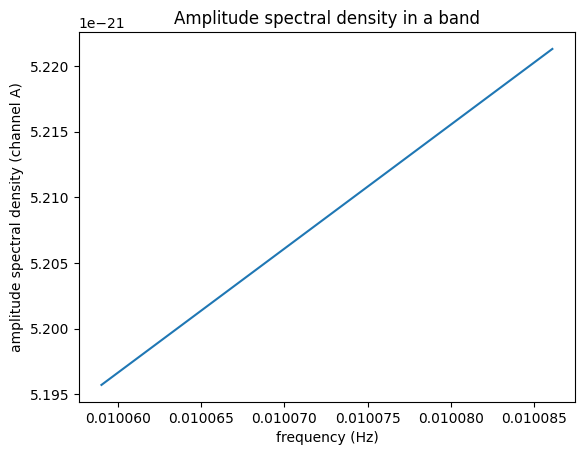

In [11]:
plt.plot(get_wrapper(sample_frequencies), get_wrapper(asd_A))
plt.title('Amplitude spectral density in a band')
plt.xlabel('frequency (Hz)')
plt.ylabel('amplitude spectral density (channel A)')
plt.show()

Finally, we stitch the waveforms into the frequency grid, and at the same time apply the whitening.

In [12]:
k_min = round(f_min/df)
k_max = round(f_max/df)
num = len(sample_frequencies)

# These indices describe how to stitch the waveform into the larger frequency grid.
i_start = (get_wrapper(gb.start_inds) - k_min).astype(cp.int32)
i_end = (get_wrapper(gb.start_inds) - k_min + gb.N).astype(cp.int32)

# PyTorch by default uses float32, and that should be sufficient for our purposes.
# Here we use complex64 since the frequency-domain strain is complex.

A_whitened = cp.empty((num_samples, num), dtype=cp.complex64)
E_whitened = cp.empty((num_samples, num), dtype=cp.complex64)

for i in range(num_samples):
    x = cp.zeros(num, dtype=cp.complex128)
    x[i_start[i]:i_end[i]] = gb.A[i]
    x *= cp.sqrt(4 * df) / asd_A
    A_whitened[i] = x

    x = cp.zeros(num, dtype=cp.complex128)
    x[i_start[i]:i_end[i]] = gb.E[i]
    x *= cp.sqrt(4 * df) / asd_E
    E_whitened[i] = x

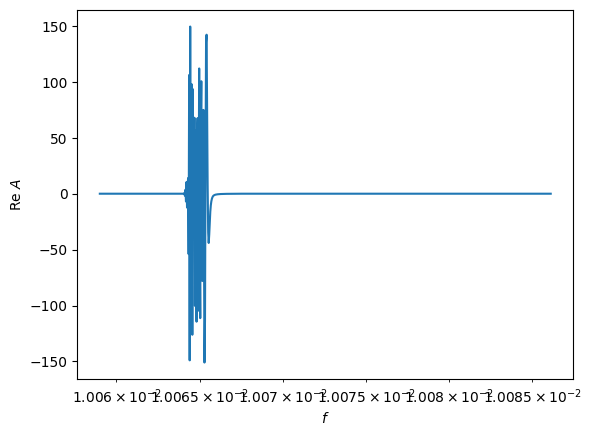

In [13]:
# Plot a sample waveform
plt.plot(get_wrapper(sample_frequencies), get_wrapper(A_whitened[0].real))
plt.xscale('log')
plt.xlabel('$f$')
plt.ylabel('Re $A$')

plt.show()

### Package into a pytorch Dataset

The `Dataset` is a convenient class for storing and accessing pairs of parameters and associated data. It must define the following methods:

* `__len__()`: Return total number of samples in the dataset.
* `__getitem__(idx)`: Retrieve a $(\theta, d)$ pair of parameters and data. We use this method to also add (in real time) a noise realization to each simulated waveform. (Therefore repeated calls will give different noise realizations).


In [14]:
# For best training, parameters should be standardized (zero mean, unit variance across the training set).

parameters_mean = np.mean(sampling_parameters, axis=0)
parameters_std = np.std(sampling_parameters, axis=0)

parameters_standardized = (sampling_parameters - parameters_mean) / parameters_std
parameters_standardized = parameters_standardized.astype(np.float32)

In [15]:
# Prepare the (complex) frequency-domain data for the (real) neural network. To do so we simply concatenate the real and imaginary parts into an array of doubled length.


waveforms = cp.concatenate((cp.expand_dims(A_whitened, axis=1).real, cp.expand_dims(A_whitened, axis=1).imag,
                            cp.expand_dims(E_whitened, axis=1).real, cp.expand_dims(E_whitened, axis=1).imag),axis=1)

print(waveforms.shape)

(10000, 4, 855)


In [16]:
class WaveformDataset(Dataset):

    def __init__(self, parameters, waveforms):
        self.parameters = parameters
        self.waveforms = waveforms

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        params = self.parameters[idx]
        signal = self.waveforms[idx]

        # Add unit normal noise to the signal
        noise = cp.random.normal(size = signal.shape).astype(cp.float32)
        data = signal + noise

        return torch.tensor(data).type(dtype), torch.tensor(params).type(dtype)

In [17]:
waveform_dataset = WaveformDataset(parameters_standardized, waveforms)

tensor([-1.2861,  0.7500], device='cuda:0')


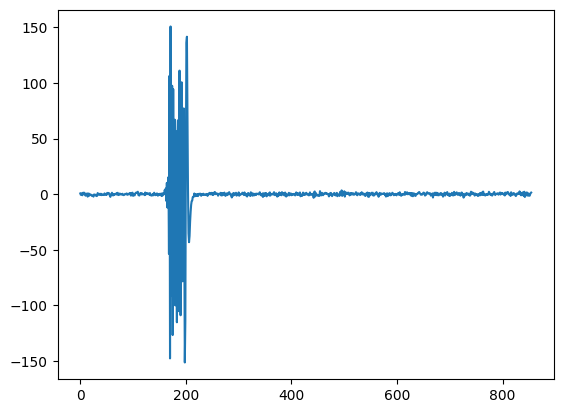

In [18]:
# We can sample from the WaveformDataset. This gives us pairs of data and parameters, different noise realizations each time.

x, y = waveform_dataset[0]
print(y)
plt.plot(x[0].cpu())
plt.show()

## Point parameter estimation.

We now try to take the imput data and fit it to the corresponding parameters.

Model construction

We start with the simple CNN model which combines a set of different layers using `torch.nn.Sequential`

In [62]:
# Excercise: define the model of CNN network.
# Number of input channels: 4
# Number of output layers: 2
# Suggestions:
# 1) Use additional layers to stabilise your network: BatchNorm1d, nn.MaxPool1d.
# 2) After couple of Convolutional layer, flatten your network (for example with the layer nn.Flatten())
# and use a couple of fully connected layers.



In [83]:
model = nn.Sequential(
        nn.Conv1d(4, 32, kernel_size=7, padding="same"),
        nn.BatchNorm1d(32, track_running_stats=True),

        nn.ELU(),

        nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ELU(),
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.MaxPool1d(2),
        nn.ELU(),
        nn.Flatten(),

        nn.LazyLinear(1024),
        nn.ELU(),

        nn.LazyLinear(128),
        nn.ELU(),
        nn.Dropout(0.1),

        nn.LazyLinear(2)

    ).to('cuda')


### Training

In [84]:
# Split the dataset into training and test sets. We use the test set to make sure the network properly generalizes to data that it has not seen in training, i.e., it does not overfit.

train_fraction = 0.8
num_train = int(round(train_fraction * num_samples))
num_test = num_samples - num_train
train_dataset, test_dataset = random_split(waveform_dataset, [num_train, num_test])

# The DataLoader is used in training.

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [85]:
# The DataLoaders iterate over samples, returning torch tensors containing a batch of data.

train_features, train_labels = next(iter(train_dataloader))


In [86]:
# We use the Adam optimizer.

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=1e-4)

Define loss function

In [87]:
# Exercise: Define loss function

loss_func = nn.MSELoss()


In [88]:
# Training and test loops.

def train_loop(dataloader, model, optimizer):
    model.train()

    size = len(dataloader.dataset)
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        outputs = model(X)
        loss = loss_func(outputs, y)

        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")

    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss


In [89]:
# Excercise: Implement test loop
#            It should use test data and do not back propagate the gradient

# testing and test loops.

def test_loop(dataloader, model):

    model.eval()

    size = len(dataloader.dataset)
    test_loss = 0
    with torch.inference_mode():
      for batch, (X, y) in enumerate(dataloader):
          outputs = model(X)
          loss = loss_func(outputs, y)

          test_loss += loss.detach().sum()
          loss = loss.mean()

          if batch % 20 == 0:
              loss, current = loss.item(), batch * len(X)
              print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")

    average_loss = test_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss


In [90]:
epochs = 20
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, model, optimizer)
    train_history.append(loss)
    loss = test_loop(test_dataloader, model)
    test_history.append(loss)
print("Done!")

Epoch 1
-------------------------------
Loss: 0.977592  [    0/ 8000 samples]
Loss: 0.113176  [ 5120/ 8000 samples]
Average loss: 0.0008
Loss: 0.072252  [    0/ 2000 samples]
Average loss: 0.0003
Epoch 2
-------------------------------
Loss: 0.073103  [    0/ 8000 samples]
Loss: 0.040495  [ 5120/ 8000 samples]
Average loss: 0.0002
Loss: 0.034318  [    0/ 2000 samples]
Average loss: 0.0001
Epoch 3
-------------------------------
Loss: 0.049578  [    0/ 8000 samples]
Loss: 0.035639  [ 5120/ 8000 samples]
Average loss: 0.0002
Loss: 0.025721  [    0/ 2000 samples]
Average loss: 0.0001
Epoch 4
-------------------------------
Loss: 0.051132  [    0/ 8000 samples]
Loss: 0.037740  [ 5120/ 8000 samples]
Average loss: 0.0001
Loss: 0.022991  [    0/ 2000 samples]
Average loss: 0.0001
Epoch 5
-------------------------------
Loss: 0.030019  [    0/ 8000 samples]
Loss: 0.026556  [ 5120/ 8000 samples]
Average loss: 0.0001
Loss: 0.029427  [    0/ 2000 samples]
Average loss: 0.0001
Epoch 6
------------

<class 'list'>


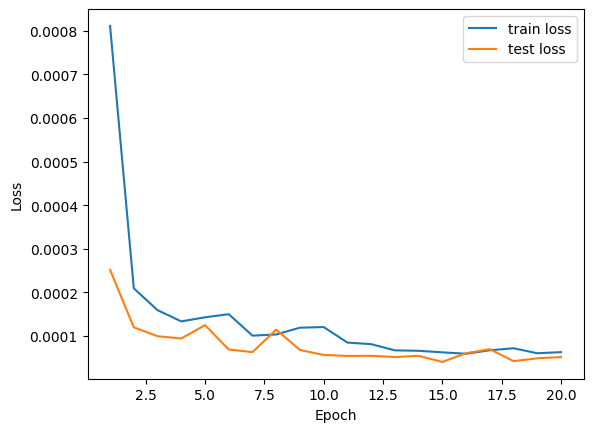

In [91]:
epochs = np.arange(1, len(train_history) + 1)
print(type(test_history))
plt.plot(epochs, train_history, label = 'train loss')
plt.plot(epochs, test_history, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [92]:
test_features, test_labels = next(iter(test_dataloader))
test_outputs = model(test_features)


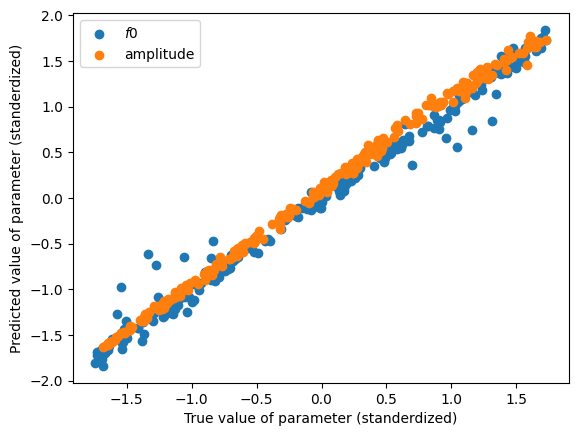

In [94]:
plt.scatter(test_labels[:,0].cpu(), test_outputs[:,0].cpu().detach().numpy(), label = '$f0$')
plt.scatter(test_labels[:,1].cpu(), test_outputs[:,1].cpu().detach().numpy(), label = 'amplitude')
plt.xlabel('True value of parameter (standerdized)')
plt.ylabel('Predicted value of parameter (standerdized)')
plt.legend()
plt.show()

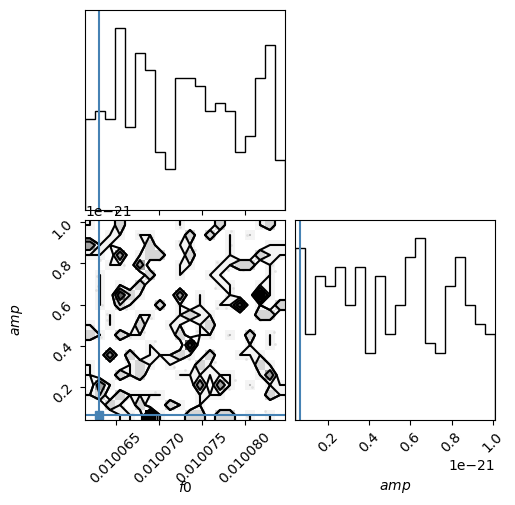

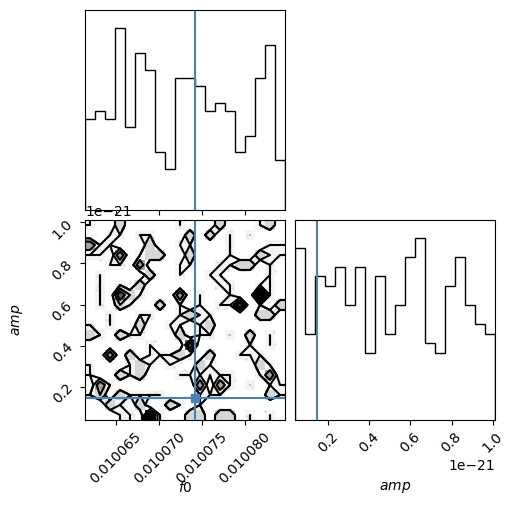

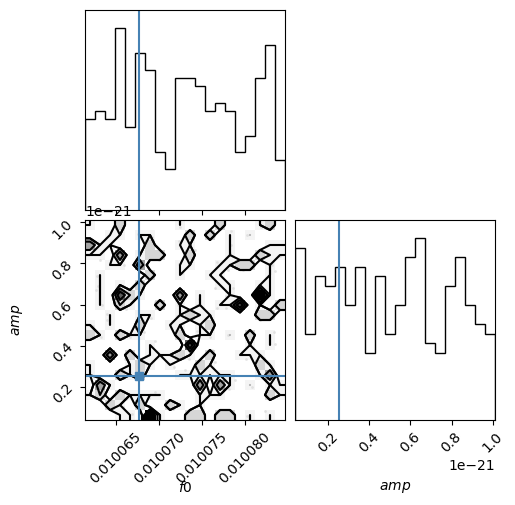

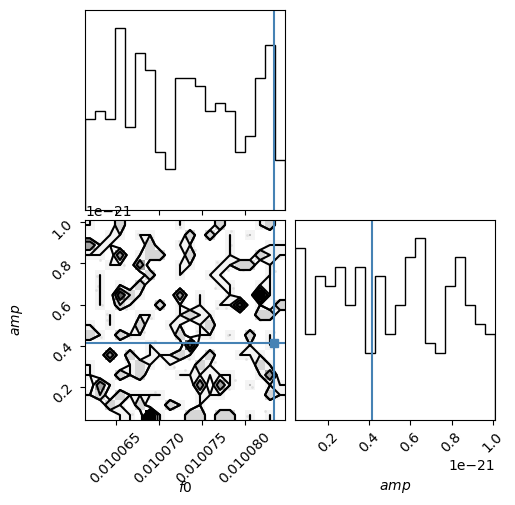

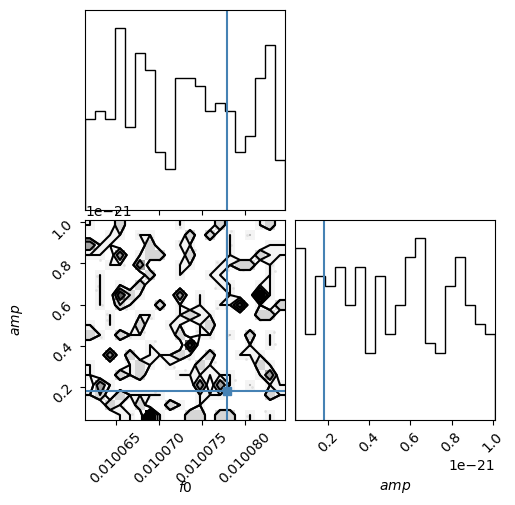

In [95]:
num_posteriors = 5
num_samples = 10000

for n in range(num_posteriors):
    test_x, test_y = test_dataset[n]

    # Repeat same wf for a number of samples
    wf = torch.tile(test_x, (num_samples, 1))

    # Predict a posterior
    pred_samples = cp.asarray(model(test_features).detach())

    # Undo the standardization
    pred_samples = parameters_std * pred_samples + parameters_mean
    truth = parameters_std * cp.asarray(test_y) + parameters_mean

    # Plot
    corner.corner(get_wrapper(pred_samples), truths=get_wrapper(truth), labels=['$f0$', '$amp$'])
    plt.show()